# NNX

Welcome to NNX!

NNX is an open source Python library for **N**eural **N**etwork in JA**X**. Its main feature is, much like Pytorch, allowing Python object semantics and reference sharing, which brings simplicty and familiarity, and easily crossing over into the functional world with through a set of simple APIs.

This tutorial demonstrates how to construct a simple convolutional neural network (CNN) using NNX and train the network for image classification on the MNIST dataset.

### Installation

In [ ]:
! pip install -q nnx

### Load the MNIST dataset
We will use the `datasets` library to load MNIST and convert it to NumPy arrays.

In [2]:
import datasets
import numpy as np

dataset = datasets.load_dataset("mnist")
X_train = np.array(np.stack(dataset["train"]["image"]), dtype=np.uint8)[..., None]
y_train = np.array(dataset["train"]["label"], dtype=np.uint8)
X_test = np.array(np.stack(dataset["test"]["image"]), dtype=np.uint8)[..., None]
y_test = np.array(dataset["test"]["label"], dtype=np.uint8)

/home/cris/nnx/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset mnist (/home/cris/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 272.61it/s]


Lets visualize a few examples from the dataset using matplotlib:

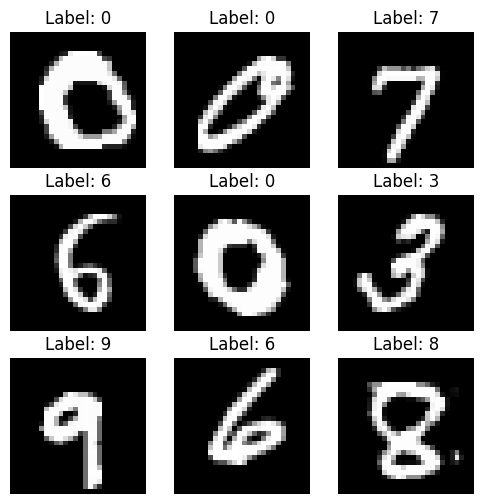

In [3]:
import matplotlib.pyplot as plt

# plot a 3x3 grid of MNIST digits
idxs = np.random.randint(0, len(X_train), size=(3, 3))
fig, axes = plt.subplots(3, 3, figsize=(3*2, 3*2))

for i in range(3):
    for j in range(3):
        axes[i, j].imshow(X_train[idxs[i, j]], cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Label: {y_train[idxs[i, j]]}")

plt.show()

### Defining the Model

To create a convolutional neural network using NNX define a `nnx.Module` subclass. We define the model by subclassing `nnx.Module` and defining a `forward` method that returns the model output. Like in PyTorch, the `__init__` method instantiates all the modules that will be used in the model. The `__call__` in this case
will define the forward computation. 

In [4]:
import jax
import jax.numpy as jnp
import nnx

class CNN(nnx.Module):
  def __init__(self, *, ctx: nnx.Context):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), ctx=ctx)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), ctx=ctx)
    self.linear1 = nnx.Linear(7*7*64, 256, ctx=ctx)
    self.linear2 = nnx.Linear(256, 10, ctx=ctx)

  def __call__(self, x: jax.Array) -> jax.Array:
    x = self.conv1(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = self.conv2(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = self.linear1(x)
    x = nnx.relu(x)
    x = self.linear2(x)
    return x
  
model = CNN(ctx=nnx.context(0))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


One notable difference with other frameworks is that `__init__`, by convention, accepts a `ctx: nnx.Context` keyword-only argument. This object is passed around to generate PRNG keys as random state is explicit in JAX.

One of the nice things about NNX is that Module contain their own state, are fully inspectable, and you can run them eargerly. For example, we can easily check out the kernel shape of the first `Conv` layer:

In [5]:

model.conv1.kernel.shape

(3, 3, 1, 32)

We can also view the entire `State` of the model using the `.get_state()` method:

In [6]:
jax.tree_map(jnp.shape, model.get_state())

State({
  'conv1/bias': Variable(
    collection='params',
    value=(32,)
  ),
  'conv1/kernel': Variable(
    collection='params',
    value=(3, 3, 1, 32)
  ),
  'conv2/bias': Variable(
    collection='params',
    value=(64,)
  ),
  'conv2/kernel': Variable(
    collection='params',
    value=(3, 3, 32, 64)
  ),
  'linear1/bias': Variable(
    collection='params',
    value=(256,)
  ),
  'linear1/kernel': Variable(
    collection='params',
    value=(3136, 256)
  ),
  'linear2/bias': Variable(
    collection='params',
    value=(10,)
  ),
  'linear2/kernel': Variable(
    collection='params',
    value=(256, 10)
  )
})

### Training in eager mode

For pedagogical purposes, we first train the model in eager mode. This will be uselful to take a look at some of NNX's features, its be more approachable for new users, and great for debugging, but it is not the recommended way to train models in JAX.

Here we will run a simple `for` loop for just 10 iterations, at each step we will sample a batch of data, define a `loss_fn` to compute the loss, and use `nnx.value_and_grad` to compute the gradients of the loss with respect to the model parameters. Using the gradients we will update the parameters using stochastic gradient descent (SGD) via a simple `tree_map` operation. Finally, we will update the model's parameters using the `.update_state` method.

In [7]:
import optax

for step in range(10):
    idxs = np.random.randint(0, len(X_train), size=32)
    x = jnp.array(X_train[idxs])
    y = jnp.array(y_train[idxs])

    def loss_fn(model: CNN):
        logits = model(x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    
    loss, grads = nnx.value_and_grad(loss_fn, wrt="params")(model)
    params = model.filter("params")
    params = jax.tree_map(lambda w, g: w - 0.001 * g, params, grads)

    model.update_state(params)
    print(f"Step {step}: loss={loss:.4f}")

Step 0: loss=61.5163
Step 1: loss=87.7966
Step 2: loss=85.9544
Step 3: loss=54.8778
Step 4: loss=10.4614
Step 5: loss=4.4263
Step 6: loss=3.5288
Step 7: loss=2.8952
Step 8: loss=1.8435
Step 9: loss=2.0249


The loss is going down 🎉.

### Training with the Functional API

Now that we have a working model, lets see how to train it with `jax.jit` using NNX's Functional API. The `Module.partition` method allows you to convert a Module into pytrees with functional semantics, this allows you to integrate with JAX's functional APIs like `jax.jit` and `jax.grad`.

In this next example we will use the `.partition` method to split the model into a `params: State` and `moduledef: ModuleDef` objects. We pass the `"params"` filter to check that the Module's state only contain `Variables` with the `params` collection. Having `params` and `moduledef` its pretty easy to implement a jitted `train_step` much like you would in Flax or Haiku. `ModuleDef` exposes an `apply` method which accepts some `State` and creates a function that runs the Module's `__call__` method. This function then returns the output of the Module along with the updated state.

In [8]:
params, moduledef = model.partition("params")

@jax.jit
def train_step(params: nnx.State, x, y):
    def loss_fn(params):
        logits, _updates = moduledef.apply(params)(x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    params = jax.tree_map(lambda w, g: w - 0.001 * g, params, grads)

    return loss, params

Using `train_step` we can run a few more iterations and see that the loss is still going down, however, this time execution should be much faster.

In [9]:
for step in range(10):
    idxs = np.random.randint(0, len(X_train), size=32)
    x = jnp.array(X_train[idxs])
    y = jnp.array(y_train[idxs])

    loss, params = train_step(params, x, y)
    print(f"Step {step}: loss={loss:.4f}")

model.update_state(params)

Step 0: loss=1.4396
Step 1: loss=1.4127
Step 2: loss=1.8718
Step 3: loss=1.7080
Step 4: loss=1.7984
Step 5: loss=1.0350
Step 6: loss=1.2076
Step 7: loss=0.9081
Step 8: loss=0.8217
Step 9: loss=0.6687


### Realistic Training using TrainState

For real training scenarios, we recommend using `TrainState` to manage the state of your training loop. `TrainState` manages the `params` of your network along with other types of state, and uses `optax` to update the parameters according to the gradients.

Next, we will define a `train_step` function that accepts a `TrainState` and a batch of data, and returns a new `TrainState` with updated parameters. The `apply_gradients` method will return a new `state` with the updated parameters. Flax users should be familiar with this API. In this case will will also define a `eval_step` function that will be used to evaluate the model on the test set and return some metrics.

In [9]:
state = nnx.TrainState(
    apply_fn=moduledef.apply,
    params=params,
    tx=optax.adam(0.001), 
)

@jax.jit
def train_step(state: nnx.TrainState, x, y):

    def loss_fn(params):
        logits, _updates = state.apply_fn(params)(x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    
    grads = jax.grad(loss_fn)(state.params)

    state = state.apply_gradients(grads=grads)

    return state

@jax.jit
def eval_step(state: nnx.TrainState, x, y):
    logits, _updates = state.apply_fn(state.params)(x)
    metrics = {
        'accuracy': jnp.mean(jnp.argmax(logits, axis=-1) == y),
        'loss': optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    }
    return metrics

Now lets create a simple training loop that runs for 1000 iterations and prints the metrics every 100 steps. At the end of training we will compute the final metrics.

In [10]:
total_steps = 1000
eval_every = 100

for step in range(total_steps):
    if step % eval_every == 0:
        metrics = eval_step(state, jnp.array(X_test), jnp.array(y_test))
        print(f"Step {step}: {metrics}")

    idxs = np.random.randint(0, len(X_train), size=32)
    x = jnp.array(X_train[idxs])
    y = jnp.array(y_train[idxs])

    state = train_step(state, x, y)

metrics = eval_step(state, jnp.array(X_test), jnp.array(y_test))
print(f"Final metrics: {metrics}")

Step 0: {'accuracy': Array(0.63119996, dtype=float32), 'loss': Array(1.1837534, dtype=float32)}
Step 100: {'accuracy': Array(0.9492, dtype=float32), 'loss': Array(0.16359854, dtype=float32)}
Step 200: {'accuracy': Array(0.9564, dtype=float32), 'loss': Array(0.14198248, dtype=float32)}
Step 300: {'accuracy': Array(0.96279997, dtype=float32), 'loss': Array(0.12757339, dtype=float32)}
Step 400: {'accuracy': Array(0.97169995, dtype=float32), 'loss': Array(0.09900841, dtype=float32)}
Step 500: {'accuracy': Array(0.96889997, dtype=float32), 'loss': Array(0.10143881, dtype=float32)}
Step 600: {'accuracy': Array(0.9745, dtype=float32), 'loss': Array(0.08513925, dtype=float32)}
Step 700: {'accuracy': Array(0.96379995, dtype=float32), 'loss': Array(0.11632324, dtype=float32)}
Step 800: {'accuracy': Array(0.97679996, dtype=float32), 'loss': Array(0.07204168, dtype=float32)}
Step 900: {'accuracy': Array(0.9765, dtype=float32), 'loss': Array(0.08413408, dtype=float32)}
Final metrics: {'accuracy': A

### Inference

Finally, now that we have a trained model, lets use it to make some predictions. We will update the `model` object with the trained parameters and use it to make predictions on the test set.

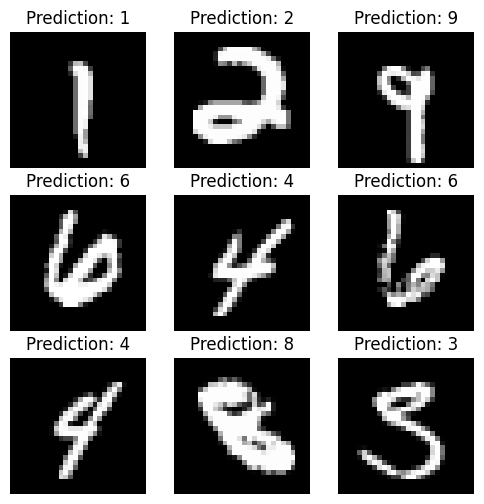

In [11]:
model.update_state(state.params)

# plot a 3x3 grid of MNIST digits
idxs = np.random.randint(0, len(X_test), size=(3, 3))
fig, axes = plt.subplots(3, 3, figsize=(3*2, 3*2))

for i in range(3):
    for j in range(3):
        logits = model(jnp.array([X_test[idxs[i, j]]]))
        axes[i, j].imshow(X_test[idxs[i, j]], cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Prediction: {jnp.argmax(logits)}")

Awesome! We hope you've enjoyed this tutorial and learned the basics of NNX.